In [1]:
import os

import matplotlib.pyplot as plt
import pytorch_lightning as pl
import segmentation_models_pytorch as smp
import torch
from lightning.pytorch.loggers import TensorBoardLogger
from torch.utils.data import DataLoader

from models.crater_model import CraterModel
from utils.dataset import CraterDataset

c:\Users\nochzato\miniconda3\envs\crater\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
IMG_DIM = 128

In [3]:
train_dataset = CraterDataset(
    img_dir=f"./dataset/geo_train_{IMG_DIM}", mask_dir=f"./dataset/mask_train_{IMG_DIM}"
)
val_dataset = CraterDataset(
    img_dir=f"./dataset/geo_val_{IMG_DIM}", mask_dir=f"./dataset/mask_val_{IMG_DIM}"
)
test_dataset = CraterDataset(
    img_dir=f"./dataset/geo_test_{IMG_DIM}", mask_dir=f"./dataset/mask_test_{IMG_DIM}"
)

n_cpus = os.cpu_count()

train_dataloader = DataLoader(
    train_dataset, batch_size=16, shuffle=True, num_workers=n_cpus
)
val_dataloader = DataLoader(
    val_dataset, batch_size=16, shuffle=False, num_workers=n_cpus
)
test_dataloader = DataLoader(
    test_dataset, batch_size=16, shuffle=False, num_workers=n_cpus
)

In [4]:
model_fpn = CraterModel(
    arch="FPN",
    encoder_name="resnet34",
    in_channels=3,
    out_classes=1,
    loss_fn=smp.losses.DiceLoss(
        mode=smp.losses.constants.BINARY_MODE, from_logits=True
    ),
    lr=2e-4,
)

c:\Users\nochzato\miniconda3\envs\crater\lib\site-packages\pytorch_lightning\utilities\parsing.py:199: Attribute 'loss_fn' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss_fn'])`.


In [5]:
logger = TensorBoardLogger("logs", name="crater_model_fpn", log_graph=True)

In [6]:
trainer = pl.Trainer(
    accelerator="gpu",
    max_epochs=100,
    logger=logger,
)

trainer.fit(
    model_fpn, train_dataloaders=train_dataloader, val_dataloaders=val_dataloader
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type     | Params
-------------------------------------
0 | model   | FPN      | 23.2 M
1 | loss_fn | DiceLoss | 0     
-------------------------------------
23.2 M    Trainable params
0         Non-trainable params
23.2 M    Total params
92.622    Total estimated model params size (MB)
c:\Users\nochzato\miniconda3\envs\crater\lib\site-packages\lightning\pytorch\loggers\tensorboard.py:194: Could not log computational graph to TensorBoard: The `model.example_input_array` attribute is not set or `input_array` was not given.


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

c:\Users\nochzato\miniconda3\envs\crater\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:436: Consider setting `persistent_workers=True` in 'val_dataloader' to speed up the dataloader worker initialization.


c:\Users\nochzato\miniconda3\envs\crater\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:436: Consider setting `persistent_workers=True` in 'train_dataloader' to speed up the dataloader worker initialization.


Epoch 0:   2%|▏         | 1/50 [00:05<04:49,  0.17it/s, v_num=0]

c:\Users\nochzato\miniconda3\envs\crater\lib\site-packages\torch\autograd\graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Epoch 99: 100%|██████████| 50/50 [00:17<00:00,  2.94it/s, v_num=0, val_loss=0.302, val_per_image_iou=0.536, val_dataset_iou=0.539, train_loss=0.238, train_per_image_iou=0.627, train_dataset_iou=0.627]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 50/50 [00:18<00:00,  2.77it/s, v_num=0, val_loss=0.302, val_per_image_iou=0.536, val_dataset_iou=0.539, train_loss=0.238, train_per_image_iou=0.627, train_dataset_iou=0.627]


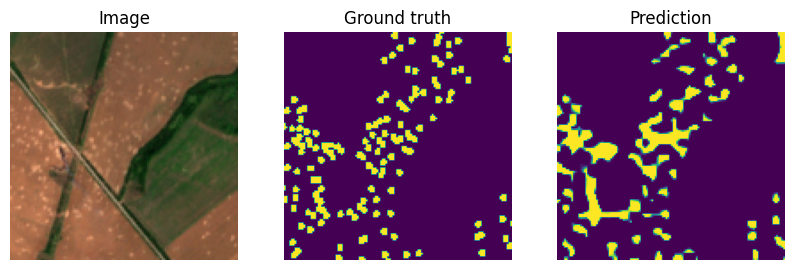

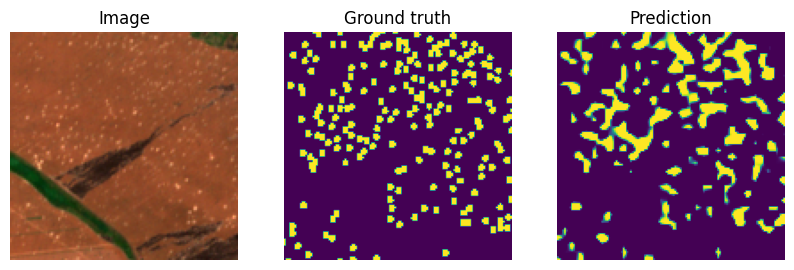

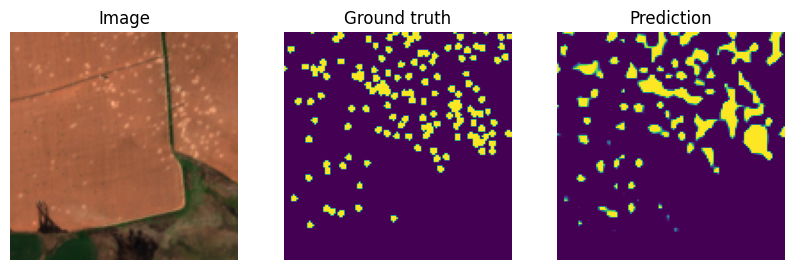

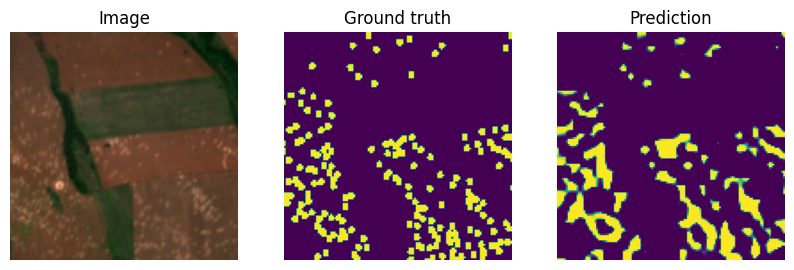

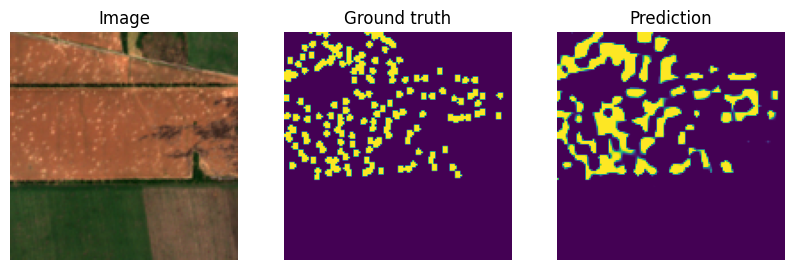

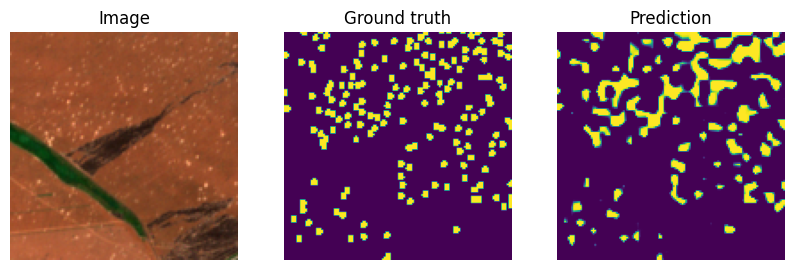

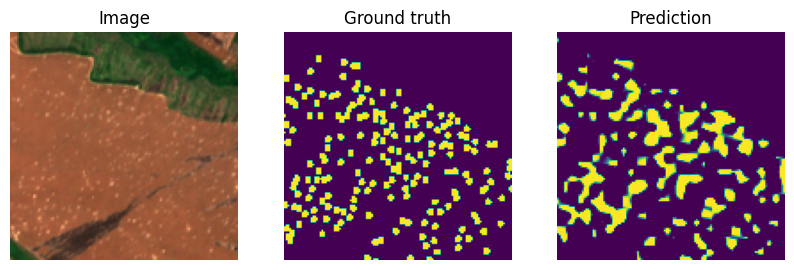

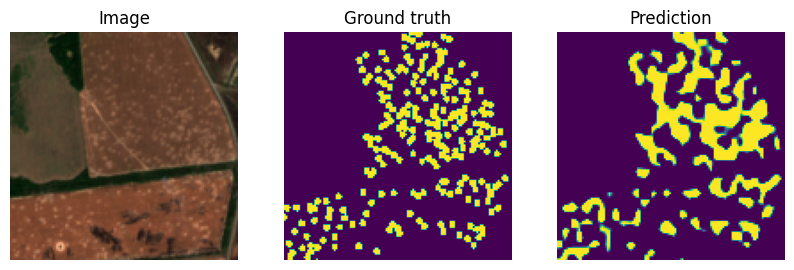

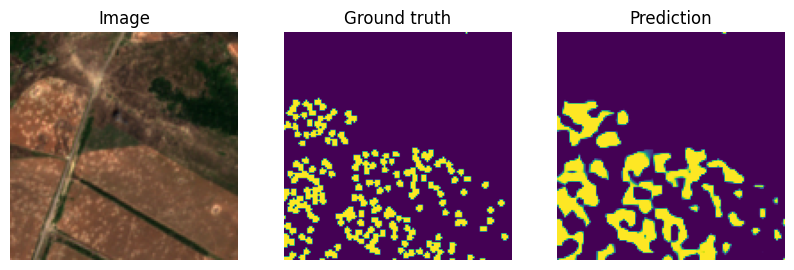

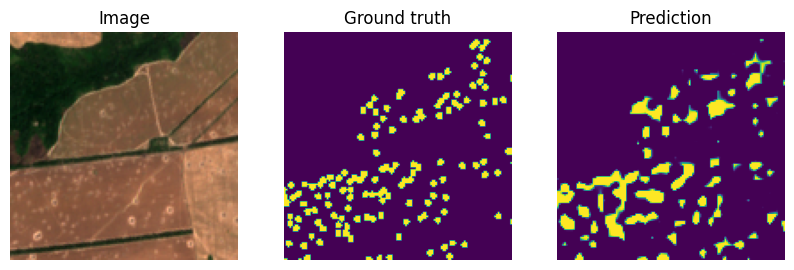

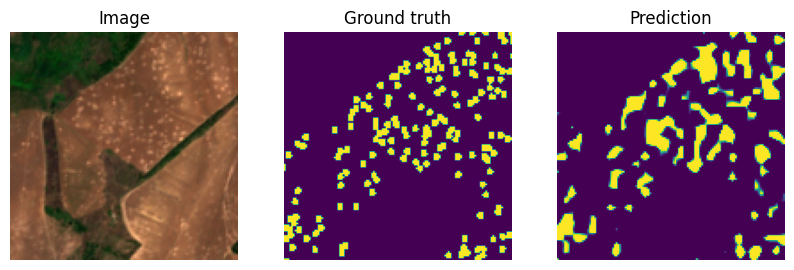

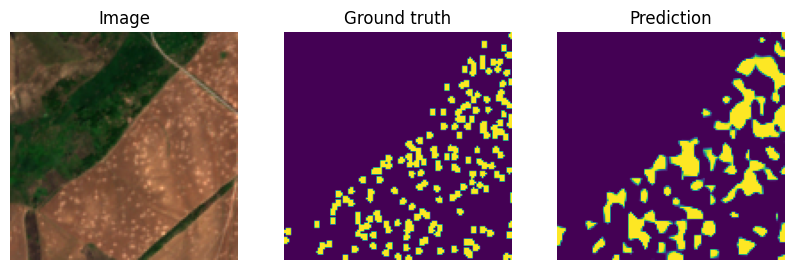

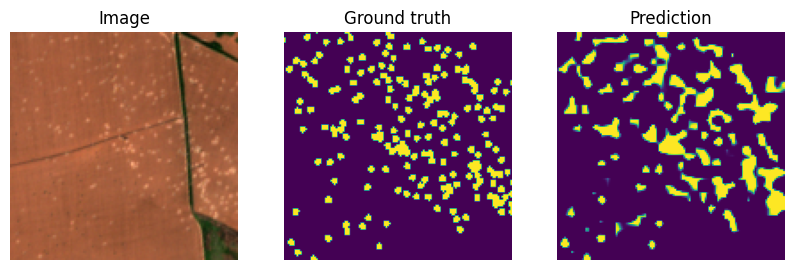

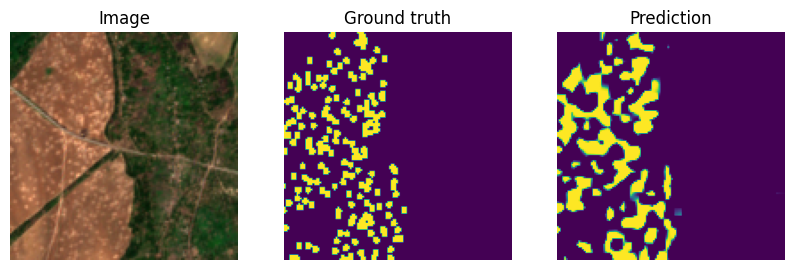

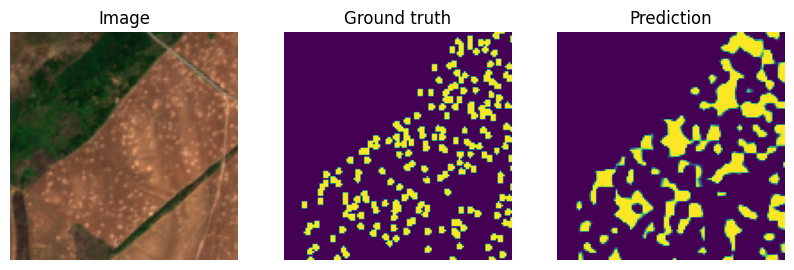

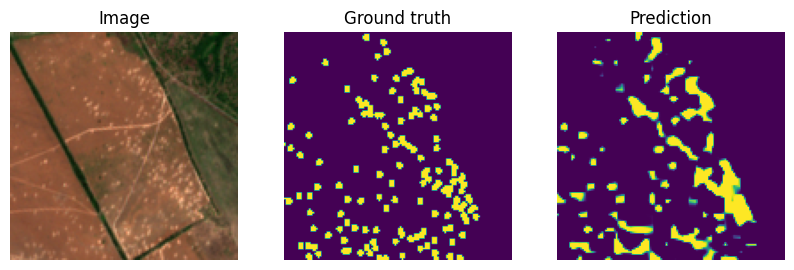

In [7]:
batch = next(iter(test_dataloader))
with torch.no_grad():
    model_fpn.eval()
    logits = model_fpn(batch["image"])
pr_masks = logits.sigmoid()

for image, gt_mask, pr_mask in zip(batch["image"], batch["mask"], pr_masks):
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 3, 1)
    plt.imshow(image.numpy().transpose(1, 2, 0))
    plt.title("Image")
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.imshow(gt_mask.numpy().squeeze())
    plt.title("Ground truth")
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.imshow(pr_mask.numpy().squeeze())
    plt.title("Prediction")
    plt.axis("off")

    plt.show()

In [4]:
model_unet = CraterModel(
    arch="Unet",
    encoder_name="resnet34",
    in_channels=3,
    out_classes=1,
    loss_fn=smp.losses.DiceLoss(
        mode=smp.losses.constants.BINARY_MODE, from_logits=True
    ),
    lr=2e-4,
)

c:\Users\nochzato\miniconda3\envs\crater\lib\site-packages\pytorch_lightning\utilities\parsing.py:199: Attribute 'loss_fn' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss_fn'])`.


In [5]:
logger = TensorBoardLogger("logs", name="crater_model_unet", log_graph=True)

In [6]:
trainer = pl.Trainer(
    accelerator="gpu",
    max_epochs=100,
    logger=logger,
)

trainer.fit(
    model_unet, train_dataloaders=train_dataloader, val_dataloaders=val_dataloader
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type     | Params
-------------------------------------
0 | model   | Unet     | 24.4 M
1 | loss_fn | DiceLoss | 0     
-------------------------------------
24.4 M    Trainable params
0         Non-trainable params
24.4 M    Total params
97.745    Total estimated model params size (MB)
c:\Users\nochzato\miniconda3\envs\crater\lib\site-packages\lightning\pytorch\loggers\tensorboard.py:194: Could not log computational graph to TensorBoard: The `model.example_input_array` attribute is not set or `input_array` was not given.


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

c:\Users\nochzato\miniconda3\envs\crater\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:436: Consider setting `persistent_workers=True` in 'val_dataloader' to speed up the dataloader worker initialization.


c:\Users\nochzato\miniconda3\envs\crater\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:436: Consider setting `persistent_workers=True` in 'train_dataloader' to speed up the dataloader worker initialization.


Epoch 0:   4%|▍         | 2/50 [00:06<02:33,  0.31it/s, v_num=0]

c:\Users\nochzato\miniconda3\envs\crater\lib\site-packages\torch\autograd\graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Epoch 99: 100%|██████████| 50/50 [00:17<00:00,  2.88it/s, v_num=0, val_loss=0.0607, val_per_image_iou=0.884, val_dataset_iou=0.887, train_loss=0.0193, train_per_image_iou=0.967, train_dataset_iou=0.968]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 50/50 [00:18<00:00,  2.69it/s, v_num=0, val_loss=0.0607, val_per_image_iou=0.884, val_dataset_iou=0.887, train_loss=0.0193, train_per_image_iou=0.967, train_dataset_iou=0.968]


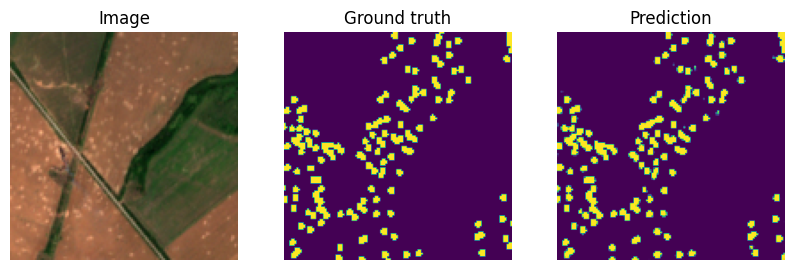

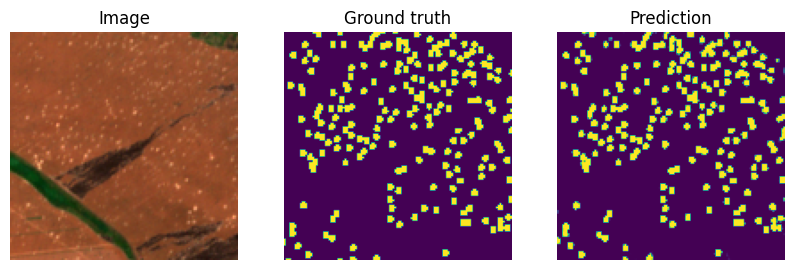

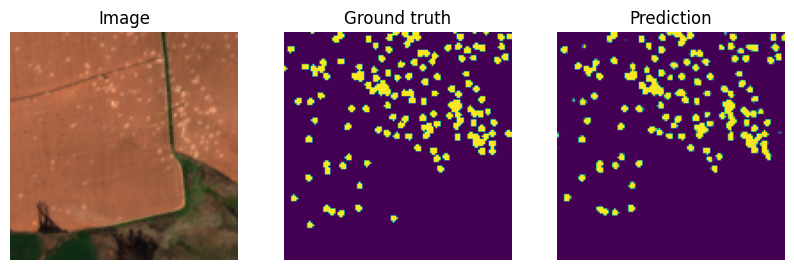

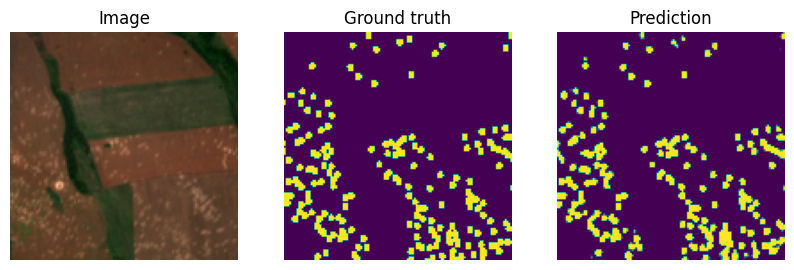

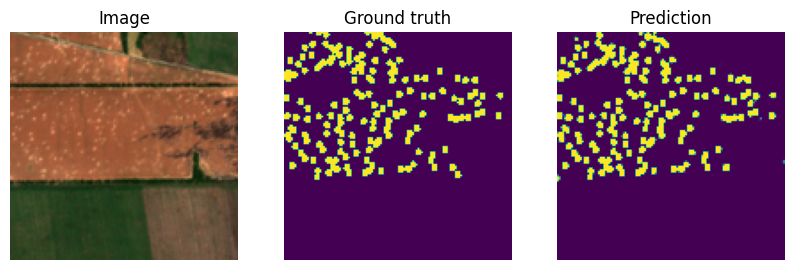

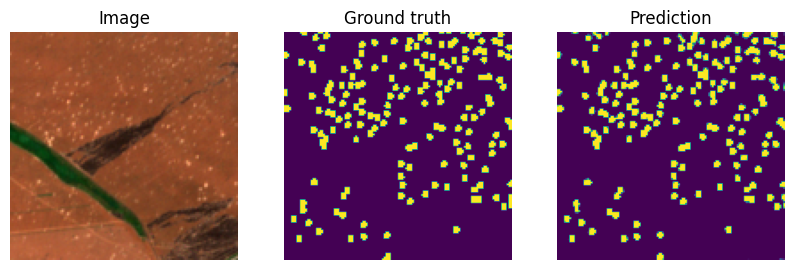

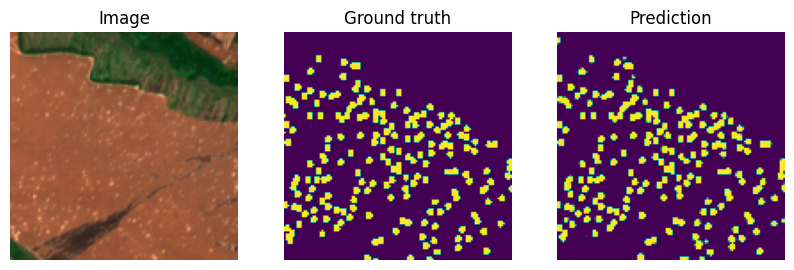

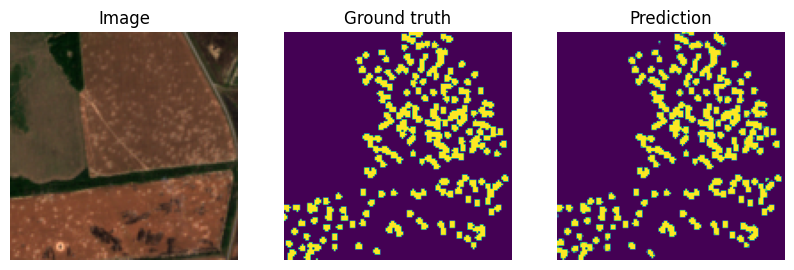

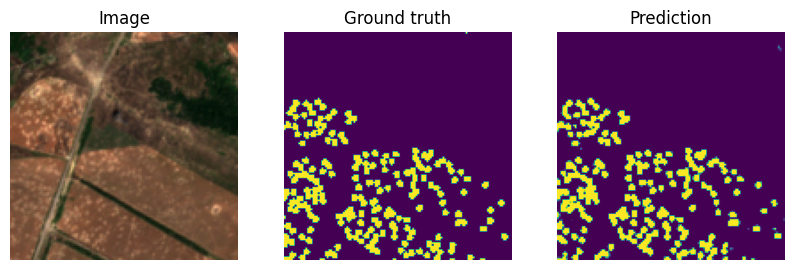

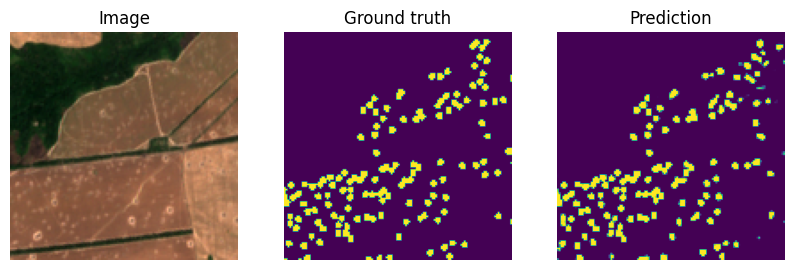

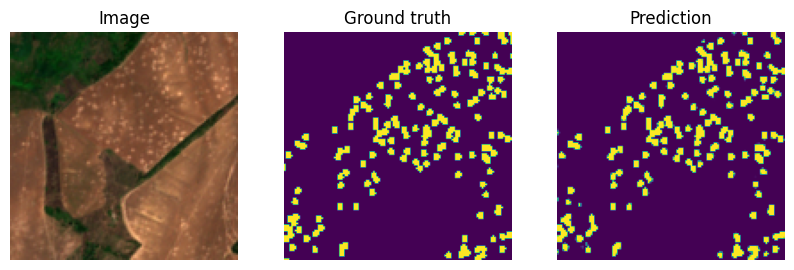

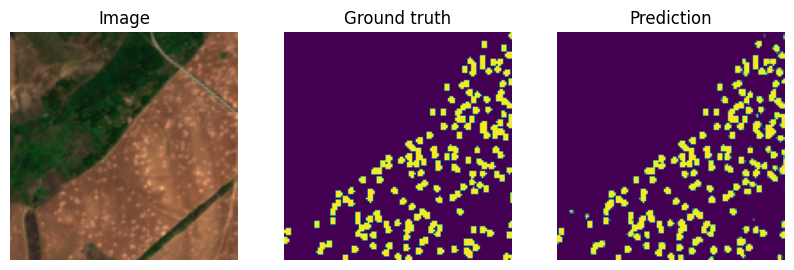

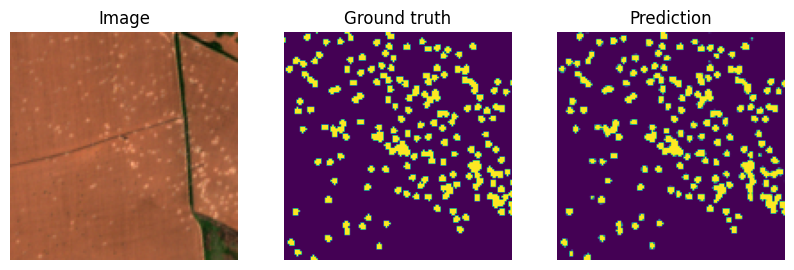

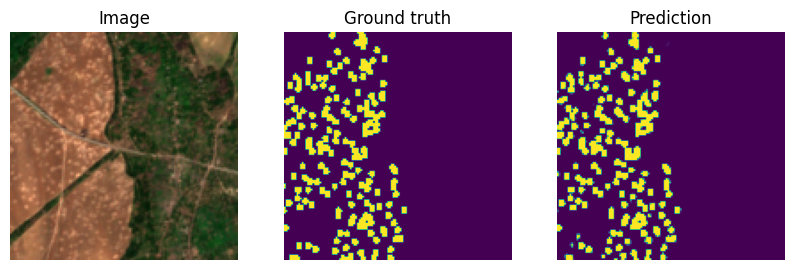

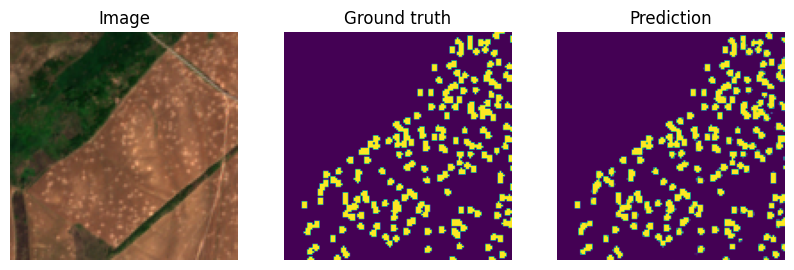

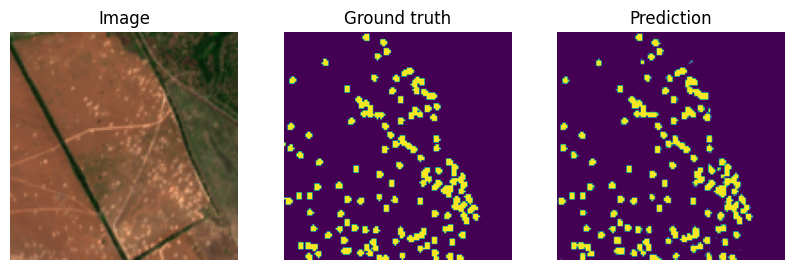

In [8]:
batch = next(iter(test_dataloader))
with torch.no_grad():


    model_unet.eval()


    logits = model_unet(batch["image"])


pr_masks = logits.sigmoid()



for image, gt_mask, pr_mask in zip(batch["image"], batch["mask"], pr_masks):


    plt.figure(figsize=(10, 5))


    plt.subplot(1, 3, 1)


    plt.imshow(image.numpy().transpose(1, 2, 0))


    plt.title("Image")


    plt.axis("off")


    plt.subplot(1, 3, 2)


    plt.imshow(gt_mask.numpy().squeeze())


    plt.title("Ground truth")


    plt.axis("off")


    plt.subplot(1, 3, 3)


    plt.imshow(pr_mask.numpy().squeeze())


    plt.title("Prediction")


    plt.axis("off")


    plt.show()